# Carregar as bibliotecas

In [125]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure
from scipy import ndimage, stats, fft
import matplotlib.pyplot as plt
from skimage.util import img_as_float, img_as_uint, img_as_ubyte

In [126]:
def show(img_list, caption_list, Axis=False, rescale = True):
    n = len(img_list)
    f, ax = plt.subplots(1,n, figsize=(10+5*(n-1),10))
    for i in range(n):
        if rescale:
            ax[i].imshow(img_list[i], cmap='gray')
        else:
            ax[i].imshow(img_list[i], cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(caption_list[i])
        if not Axis:
            ax[i].set_axis_off()

In [127]:
def log_imshow(img):
    return np.log( np.abs(img)+1 )

In [128]:
def mapping(img):
    nimg = img_as_float(img)
    mmin = np.min(nimg)
    nimg = nimg - mmin
    mmax = np.max(nimg)
    return nimg/mmax

# Questão 1
<p align="justify">Mudar a cor do fundo (*background*) da imagem apresentada a continuação, ela deve estar em tons de azul claro e o corpo do fósforo em tons de amarelo. Além disso, é fornecido a imagem binária, onde os fósforos estão representados pela cor branca e o fundo pela cor preta. Use operações aritméticas para executar o processo de modificação do fundo. A continuação são mostradas a imagem em escala de cinza e a respectiva máscara.</p>


<table><tr>
<td>
<figure><img src="https://drive.google.com/uc?id=1V3OaLUh34dRCx-53PGsUYOMb1kZ1gqzo" alt="Drawing" width="300" class="center"/>
<figcaption>Imagem em escala de cinza</figcaption>
</figure>
</td>
<td>
<figure>
<img src="https://drive.google.com/uc?id=13NOF3oDNkmNtHCHmbX_9d0-AISPEmGZe" alt="Drawing" width="300" class="center"/>
<figcaption>Máscara</figcaption>
</figure>
</td>
</tr>
</table>


<p align="justify">DICA: para conseguir modificar a intensidade do fundo, incremente um valor $inc$ nos canais vermelho e verde, e incremente um valor $2*inc$ no canal azul. Preserve as intensidades originais dos fósforos. </p>


<p align="justify">A Figura a continuação mostra o resultado final. A imagem gerada deve ser colorida e o tecido (fundo da imagem) deve aparecer na cor azul claro. </p>

<center>
<figure>
<img src="https://drive.google.com/uc?id=1BILk7RPeAuurU7dGTi-tJLxvwfkxCFv5" alt="Drawing" width="300" class="center"/>
<figcaption>Imágem resultante</figcaption>
</figure>
</center>




In [129]:
def change_background(img, mask):
    nimg = np.dstack((img, img, img))
    lin, col = img.shape[:2]
    
    inc = 50

    for i in range(lin):
        for j in range(col):
            if mask[i,j] == 0:
                nimg[i,j,0] += inc
                nimg[i,j,1] += inc
                nimg[i,j,2] += (2*inc)
            else:
                nimg[i,j,2] = nimg[i,j,2] * 0.55

    nimg = np.clip(nimg, 0, 255)
    return nimg

(600, 600, 3)


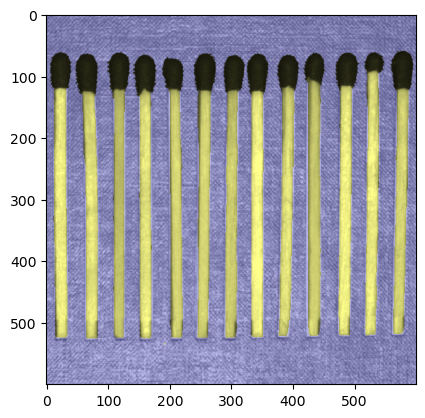

In [130]:
img = io.imread('https://drive.google.com/uc?id=1V3OaLUh34dRCx-53PGsUYOMb1kZ1gqzo')
mask = io.imread('https://drive.google.com/uc?id=13NOF3oDNkmNtHCHmbX_9d0-AISPEmGZe')
nimg = change_background(img, mask)
print(nimg.shape)
plt.imshow(nimg)

# Questão 2
<p>
A técnica de equalização de histograma permite alterar o histograma de uma imagem, porém, sempre de acordo com uma função de transformação padrão. Apesar de ser uma técnica muito atrativa, a equalização de histograma não é uma panaceia. Em muitas oportunidades o efeito produzido pela equalização não é o desejado, como o observado na figura seguinte. Na Figura da esquerda temos uma imagem muito escura de uma lua de Marte, a da direita é o resultado depois de aplicar a equalização de histograma.
</p>

<table><tr>
<td>
<figure><img src="https://drive.google.com/uc?id=1W0PYWVB1wq4HgH-nRheuJmFlkGdlFVRr" alt="Drawing" width="300" class="center"/>
<figcaption>Imagem original</figcaption>
</figure>
</td>
<td>
<figure>
<img src="https://drive.google.com/uc?id=1Ka9j-lVMYZjaG6BuGVTHl26N3S6pVyVG" alt="Drawing" width="300" class="center"/>
<figcaption>Imagem Equalizada</figcaption>
</figure>
</td>
</tr>
</table>



<p>
Vejamos como realizar essa operação. Seja $F_1$ a função de distribuição cumulativa (CDF) da imagem de entrada e $F_2$ a CDF do histograma alvo. Agora é necessário calcular o mapeamento que transforme uma intensidade da imagem de entrada de forma tal que seja similar à distribuição de intensidade do histograma alvo. Para cada intensidade $G_1$ da imagem, devemos encontrar a intensidade $G_2$ tal que: $F1(G1) = F2(G2)$.</p>

<p>
Existirá casos em que não será possível encontrar exatamente esse igualdade, nesse caso é necessário encontrar a menor diferença absoluta entre $F_1(G1)$ e $F_2(G_2)$. Em outras palavras, para mapear $M$, para cada entrada de $G_1$, encontrar a intensidade $G_2$ tal que:
</p>

$$M(G_1) = arg min_{G_2 \in [0, 255]} |F_1(G_1) - F_2(G_2)| \textrm{,    } \forall G_1 \in [0,255]$$

<p>
A operação consiste em encontrar para cada valor de $F1(G_1)$ o valor mais próximo em $F_2(G_2)$, ou seja, para cada intensidade em $G_1$, aplicar a função $F_1(G_1)$ e calcular a diferença com todos os $F_2(G_2)$ e encontrar a intensidade que gere a menor diferença e salvar essa intensidade de $G_2$ em $M$.
</p>

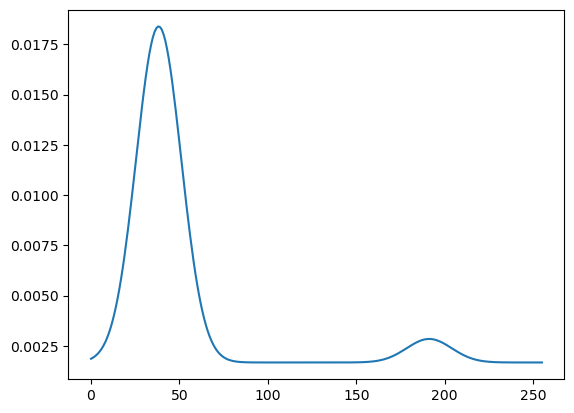

In [131]:
h = np.loadtxt('https://drive.google.com/uc?id=1n1uYESkn2TsD-8E0mH6K-4D7o1I5TwuX')
plt.plot(h)

In [132]:
def my_histogram_matching(img, hist):
    nimg = np.zeros(img.shape)

    # CDF do histograma
    cdf   = np.cumsum(hist) / np.sum(hist)
    pixel = np.linspace(0, 1, len(hist))

    inv_cdf = np.interp(np.linspace(0, 1,  img.shape[:2][0] *  img.shape[:2][1]), cdf, pixel)
    image   = inv_cdf.reshape(img.shape[:2])

    matched_image = exposure.match_histograms(img_as_float(img), img_as_float(image))
    nimg = img_as_ubyte(matched_image)

    return nimg

[[200 208 209 204]
 [203 205 205 204]
 [202 202 202 202]
 [201 202 201 195]]


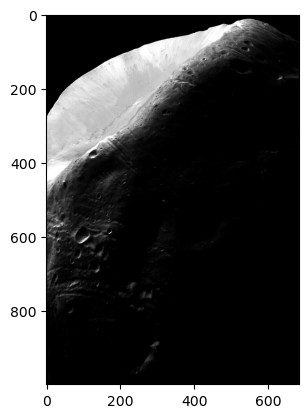

In [133]:
img_lua = io.imread('https://drive.google.com/uc?id=1W0PYWVB1wq4HgH-nRheuJmFlkGdlFVRr')
plt.imshow(img_lua, cmap='gray')
p = 200
print(img_lua[p:p+4,p:p+4])

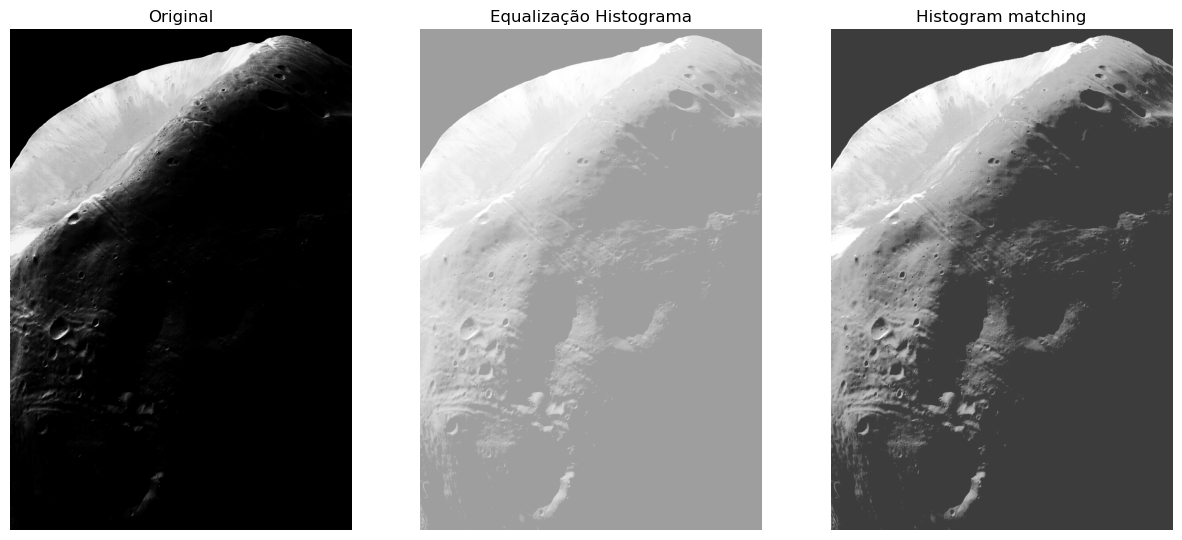

In [134]:
nimg = my_histogram_matching(img_lua, h)
img_eq = exposure.equalize_hist( img_lua, nbins = 256 )*255

f, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(img_lua, cmap='gray', vmin=0, vmax=266)
ax[1].imshow(img_eq, cmap='gray', vmin=0, vmax=255)
ax[2].imshow(nimg, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original')
ax[1].set_title('Equalização Histograma')
ax[2].set_title('Histogram matching')
for i in range(3):
  ax[i].set_axis_off()

# Questão 3
<p align="justify">
Modifique o código <i>my_histogram_matching()</i> para que receba uma segunda imagem como parâmetro. Essa segunda imagem será usada para ajustar seu histograma cumulativo e corresponda ao da outra.
</p>

In [135]:
def my_histogram_matching2(img, img_target):
  nimg = exposure.match_histograms(img_as_float(img), img_as_float(img_target))
  return nimg

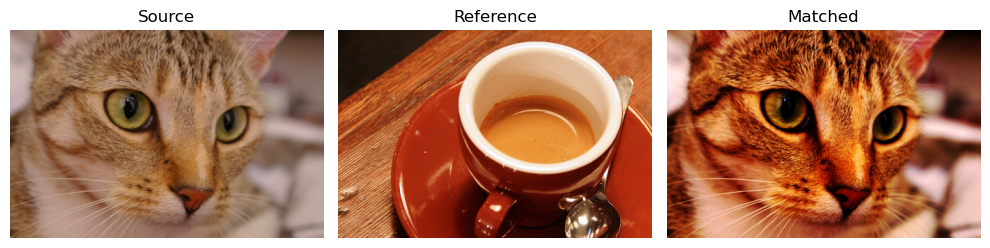

In [136]:
reference = data.coffee()
image = data.chelsea()

#matched = exposure.match_histograms(image, reference, channel_axis=2)
matched = my_histogram_matching2(image, reference)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 5),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()

# Questão 4
<p align="justify">
Implementar o método de realce de imagens, onde $$f_{highpass}(x,y) = (1+G).f(x,y)-G.f_{mean}(x,y)$$
onde $0 \leq G \leq 2$
</p>

In [137]:
def enhance(img, G=2, sigma=1):
    nimg = img_as_float(img)
    fmean = ndimage.gaussian_filter(nimg, sigma=sigma)
    
    highpass = (1 + G) * nimg - G * fmean
    
    highpass = np.clip(highpass, 0, 1)
    
    return highpass

In [138]:
lenna = io.imread('https://drive.google.com/uc?id=1k0FG4pT6WMjFeG-V63OBXNS7_CvfY5m_', as_gray=True)

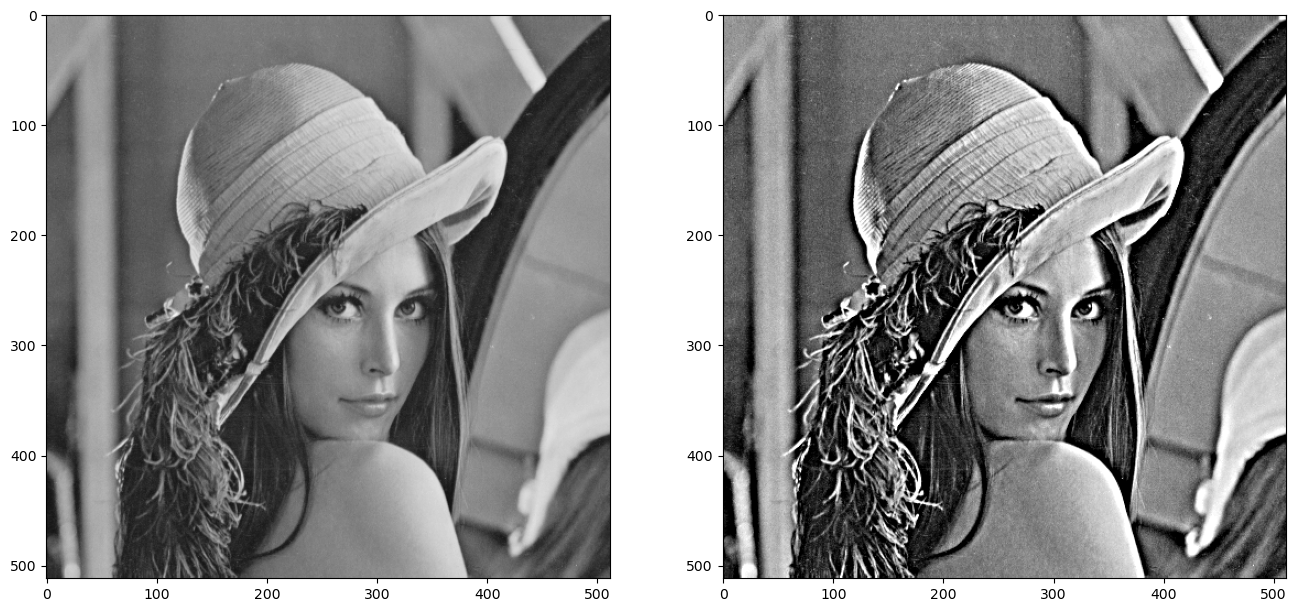

In [139]:
nimg = enhance(lenna, G=2, sigma=5)
f,ax = plt.subplots(1,2,figsize=(16,16))
ax[0].imshow(lenna, cmap='gray', vmin=0, vmax=1)
ax[1].imshow(nimg, cmap='gray', vmin=0, vmax=1)

## Questão 5

<p>Modifique o código da questão 4 para que realce as bordas de imagens coloridas</p>

In [140]:
def enhance_color(img):
    nimg = img_as_float(img)
    nimg = color.rgb2hsv(nimg)
    nimg[:,:,2] = enhance(nimg[:,:,2], G=4, sigma=5)
    nimg = color.hsv2rgb(nimg)
    return nimg

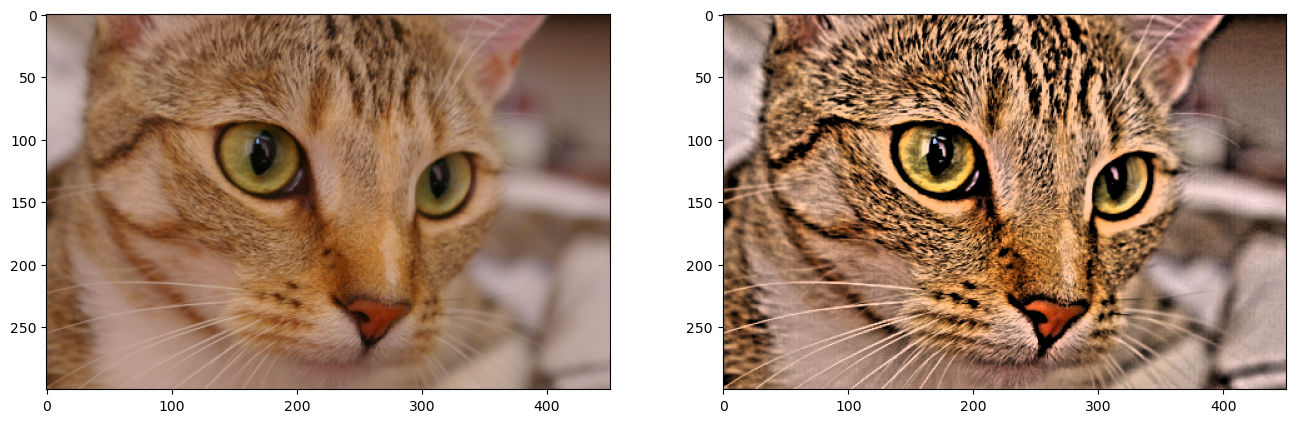

In [141]:
gato = data.chelsea()
nimg = enhance_color(gato)
f,ax = plt.subplots(1,2,figsize=(16,16))
ax[0].imshow(gato)
ax[1].imshow(nimg, vmin=0, vmax=1)